In [1]:
import warnings
import time
import os

# RASTERIO_BEST_PRACTICES = dict(  # See https://github.com/pangeo-data/cog-best-practices
#     CURL_CA_BUNDLE="/etc/ssl/certs/ca-certificates.crt",
#     GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
#     AWS_NO_SIGN_REQUEST="YES",
#     GDAL_MAX_RAW_BLOCK_CACHE_SIZE="200000000",
#     GDAL_SWATH_SIZE="200000000",
#     VSI_CURL_CACHE_SIZE="200000000",
# )
# os.environ.update(RASTERIO_BEST_PRACTICES)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
# from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

import rasterio
import rasterio.warp
import rasterio.mask
import shapely.geometry
import geopandas as gpd
import dask_geopandas
# from dask.distributed import Client
# from dask_gateway import GatewayCluster

import pystac_client
import planetary_computer as pc
from dask.distributed import Client, progress
import rioxarray

import sys
import os
current_folder = os.getcwd()
sys.path.insert(0, current_folder+'/raster')
sys.path.insert(0, current_folder+'/models')


In [2]:
#Set switch to toggle b/w local and kubernetes cluster
LOCAL = False
LOCAL = True

In [3]:
def create_centroids_gdf(gdf):
    #Convert to equal area projection and back to avoid CRS issues with calculating centroid:
    c = kde_gdf.to_crs('+proj=cea').centroid.to_crs(gdf.crs)

    centroids = pd.DataFrame()
    centroids['grid_id'] = gdf.grid_id
    centroids['lon'] = c.x.values
    centroids['lat'] = c.y.values
    centroids = gpd.GeoDataFrame(centroids, geometry=gpd.points_from_xy(centroids['lon'], centroids['lat']))
    
    return centroids

def create_centroids_val_gdf(gdf):
    columns_to_keep = ['latitude','longitude','geometry']
    centroids_val = gdf[columns_to_keep].copy()
    #rename columns
    centroids_val.rename(columns = {'latitude':'lat', 'longitude':'lon'}, inplace = True)
    
    return centroids_val


def _query(points):
    """
    Find a STAC item for points in the `points` DataFrame

    Parameters
    ----------
    points : geopandas.GeoDataFrame
        A GeoDataFrame

    Returns
    -------
    geopandas.GeoDataFrame
        A new geopandas.GeoDataFrame with a `stac_item` column containing the STAC
        item that covers each point.
    """
    intersects = shapely.geometry.mapping(points.unary_union.convex_hull) #TODO replace with rectangular geometry

    search_start = "2019-01-01"
    search_end = "2019-12-31"
    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1",
                                        modifier=pc.sign_inplace)
    # catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

    # The time frame in which we search for non-cloudy imagery
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        intersects=intersects,
        datetime=[search_start, search_end],
        query={"eo:cloud_cover": {"lt": 10}},
        limit=500,
    )
    ic = search.get_all_items_as_dict()

    features = ic["features"]
    features_d = {item["id"]: item for item in features}

    data = {
        "eo:cloud_cover": [],
        "geometry": [],
    }

    index = []

    for item in features:
        data["eo:cloud_cover"].append(item["properties"]["eo:cloud_cover"])
        data["geometry"].append(shapely.geometry.shape(item["geometry"]))
        index.append(item["id"])

    items = gpd.GeoDataFrame(data, index=index, geometry="geometry").sort_values(
        "eo:cloud_cover"
    )
    point_list = points.geometry.tolist()

    point_items = []
    for point in point_list:
        covered_by = items[items.covers(point)]
        if len(covered_by):
            point_items.append(features_d[covered_by.index[0]])
        else:
            # There weren't any scenes matching our conditions for this point (too cloudy)
            point_items.append(None)

    return points.assign(stac_item=point_items)


dask_geopandas_partitions = 250

def add_sentinel_urls(centroids,mode="train"):
    
    print("Organizing grid centroids according to Hilbert distance...")

    ddf = dask_geopandas.from_geopandas(centroids, npartitions=1)
    hd = ddf.hilbert_distance().compute()
    centroids["hd"] = hd
    centroids = centroids.sort_values("hd")
    dgdf = dask_geopandas.from_geopandas(centroids, npartitions=dask_geopandas_partitions, sort=False)

    # client, cluster = None
    
    try:
        print("Attemping to create a new dask client")
        
        if not LOCAL:
            from dask_gateway import GatewayCluster
            cluster = GatewayCluster()  # Creates the Dask Scheduler. Might take a minute.
            client = cluster.get_client()
            cluster.adapt(minimum=4, maximum=113)

            print(cluster.dashboard_link)
            print(client)
            
        else:
            from dask.distributed import Client, LocalCluster
            import multiprocessing as mp
            import dask
            dask.config.set(**{"distributed.dashboard.link": "/user/{JUPYTERHUB_USER}/proxy/{port}/status"})
            cluster = LocalCluster()
            client = Client(cluster)
            # cluster.adapt(minimum=1, maximum=mp.cpu_count())
            cluster.scale(mp.cpu_count())
            # print(cluster.dashboard_link)
            print(client)
            

        meta = dgdf._meta.assign(stac_item=[])
        df2 = dgdf.map_partitions(_query, meta=meta).compute()

        
        data = df2.dropna(subset=["stac_item"])
        #Save it as a tuple -> (RGB,NIR)
        data['urls'] = [(item["assets"]["visual"]["href"], item["assets"]["B08"]["href"]) for item in data.stac_item.tolist()]
        data['crs']  = [item["properties"]["proj:epsg"] for item in data.stac_item.tolist()]
        print(data.stac_item[0]["properties"]["proj:epsg"])
        print("{} URLs acquired. Shutting Down Cluster".format(len(data)))
        
        # if not LOCAL:
        cluster.close()
        
        if mode=="train":
            data = data.drop(['hd','stac_item'], axis=1).set_index('grid_id').reset_index(drop=True)
        else:
            data = data.drop(['hd','stac_item'], axis=1).reset_index(drop=True)
        return data
    
    except Exception as e:
        print("Error thrown: ",e)
        cluster.close()
        return None
    

# Read Observations

## KDE

In [4]:
BUCKET_NAME = 'datasets-sdm'
folder = 'kde/ca'
filename = 'geolifeclef_ca_0.05deg_kde_0.5deg_epanechnikov.pkl'

s3_read_path = 's3://{}/{}/{}'.format(BUCKET_NAME, folder, filename)
print(s3_read_path)

s3://datasets-sdm/kde/ca/geolifeclef_ca_0.05deg_kde_0.5deg_epanechnikov.pkl


In [5]:
kde_gdf = pd.read_pickle(s3_read_path)
kde_gdf.head()

,geometry,grid_id,prob_4911,prob_4912,prob_4922,prob_4923,prob_2329,prob_4927,prob_4930,prob_4382,...,prob_14228,prob_202,prob_9006,prob_272,prob_16726,prob_17029,prob_8230,prob_13366,prob_16533,prob_1455
0,"POLYGON ((-124.36556 40.23088, -124.36556 40.2...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"POLYGON ((-124.36556 40.28088, -124.36556 40.3...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"POLYGON ((-124.36556 40.33088, -124.36556 40.3...",2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"POLYGON ((-124.36556 40.38088, -124.36556 40.4...",3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"POLYGON ((-124.36556 40.43088, -124.36556 40.4...",4,0,0,24,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Val observations

In [6]:
filename = 'ca_val_obs.pkl'
s3_read_path = 's3://{}/{}/{}'.format(BUCKET_NAME, folder, filename)
print(s3_read_path)

s3://datasets-sdm/kde/ca/ca_val_obs.pkl


In [7]:
ca_val_gdf = pd.read_pickle(s3_read_path)
ca_val_gdf.head()

,observation_id,latitude,longitude,species_id,geometry,prob_4911,prob_4912,prob_4922,prob_4923,prob_2329,...,prob_14228,prob_202,prob_9006,prob_272,prob_16726,prob_17029,prob_8230,prob_13366,prob_16533,prob_1455
0,20000282,41.523970,-124.045616,2560,POINT (-124.04562 41.52397),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20001056,38.354510,-122.514270,5205,POINT (-122.51427 38.35451),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20001135,38.807053,-122.369255,5243,POINT (-122.36925 38.80705),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20002394,34.023647,-118.417330,5544,POINT (-118.41733 34.02365),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20003318,35.178210,-120.745760,5109,POINT (-120.74576 35.17821),0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
assert(ca_val_gdf.prob_5309.sum() == 13.) #Should be 13.0

# Centroids

## Generate a list of centroids for every grid_id [KDE]

In [9]:
centroids = create_centroids_gdf(kde_gdf)
centroids.head()

,grid_id,lon,lat,geometry
0,0,-124.390558,40.255879,POINT (-124.39056 40.25588)
1,1,-124.390558,40.305879,POINT (-124.39056 40.30588)
2,2,-124.390558,40.355879,POINT (-124.39056 40.35588)
3,3,-124.390558,40.405879,POINT (-124.39056 40.40588)
4,4,-124.390558,40.455879,POINT (-124.39056 40.45588)


## Fetch their URLs for Sentinel-2

In [10]:
%%time
centroids = add_sentinel_urls(centroids)

Organizing grid centroids according to Hilbert distance...
Attemping to create a new dask client


2022-12-10 03:12:21,689 - distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/sdm-geolifeCLEF/dask-worker-space/worker-ddczeyvg', purging
2022-12-10 03:12:21,689 - distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/sdm-geolifeCLEF/dask-worker-space/worker-_rshkx9c', purging
2022-12-10 03:12:21,689 - distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/sdm-geolifeCLEF/dask-worker-space/worker-udwv6tpc', purging
2022-12-10 03:12:21,689 - distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/sdm-geolifeCLEF/dask-worker-space/worker-4xgut1ui', purging
2022-12-10 03:12:21,690 - distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/sdm-geolifeCLEF/dask-worker-space/worker-y416q3zo', purging
2022-12-10 03:12:21,690 - distributed.diskutils - INFO - Found stale lock file and directory '/home/jovyan/sdm-geolifeCLEF/dask-worker-space/worker-4fs_1kj0', purgin

<Client: 'tcp://127.0.0.1:40065' processes=4 threads=4, memory=27.00 GiB>
32610
17173 URLs acquired. Shutting Down Cluster
CPU times: user 3.77 s, sys: 985 ms, total: 4.76 s
Wall time: 42.5 s


In [11]:
centroids

,lon,lat,geometry,urls,crs
0,-119.590558,33.25588,POINT (-119.59056 33.25588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
1,-119.490558,33.20588,POINT (-119.49056 33.20588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
2,-119.440558,33.20588,POINT (-119.44056 33.20588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
3,-119.440558,33.25588,POINT (-119.44056 33.25588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
4,-119.490558,33.25588,POINT (-119.49056 33.25588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
...,...,...,...,...,...
17168,-114.590558,32.80588,POINT (-114.59056 32.80588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
17169,-114.540558,32.80588,POINT (-114.54056 32.80588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
17170,-114.540558,32.85588,POINT (-114.54056 32.85588),(https://sentinel2l2a01.blob.core.windows.net/...,32611
17171,-114.490558,32.85588,POINT (-114.49056 32.85588),(https://sentinel2l2a01.blob.core.windows.net/...,32611


In [12]:
centroids.urls[17000]

('https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/11/S/PS/2019/11/17/S2A_MSIL2A_20191117T182641_N0212_R127_T11SPS_20201003T172221.SAFE/GRANULE/L2A_T11SPS_A023004_20191117T183204/IMG_DATA/R10m/T11SPS_20191117T182641_TCI_10m.tif?st=2022-12-09T03%3A12%3A24Z&se=2022-12-17T03%3A12%3A24Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-12-10T03%3A12%3A23Z&ske=2022-12-17T03%3A12%3A23Z&sks=b&skv=2021-06-08&sig=0%2B5q9lFstU0585FamhfPEqA3EjdKQXxceNJ3HOVwgz8%3D',
 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/11/S/PS/2019/11/17/S2A_MSIL2A_20191117T182641_N0212_R127_T11SPS_20201003T172221.SAFE/GRANULE/L2A_T11SPS_A023004_20191117T183204/IMG_DATA/R10m/T11SPS_20191117T182641_B08_10m.tif?st=2022-12-09T03%3A12%3A24Z&se=2022-12-17T03%3A12%3A24Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-12-10T03%3A12%3A23Z&ske=2022-12-17T03%3A12%3A23Z&

## Same for val observations

In [13]:
centroids_val = create_centroids_val_gdf(ca_val_gdf)
centroids_val

,lat,lon,geometry
0,41.523970,-124.045616,POINT (-124.04562 41.52397)
1,38.354510,-122.514270,POINT (-122.51427 38.35451)
2,38.807053,-122.369255,POINT (-122.36925 38.80705)
3,34.023647,-118.417330,POINT (-118.41733 34.02365)
4,35.178210,-120.745760,POINT (-120.74576 35.17821)
...,...,...,...
5020,37.493600,-122.368350,POINT (-122.36835 37.49360)
5021,38.026356,-119.249990,POINT (-119.24999 38.02636)
5022,38.826870,-122.349720,POINT (-122.34972 38.82687)
5023,37.211212,-120.842026,POINT (-120.84203 37.21121)


## Drop some stuff to make it look like the observations data

In [14]:
columns_to_drop = ['latitude','longitude', 'observation_id','species_id','geometry']
ca_val_gdf2 = ca_val_gdf.drop(columns_to_drop, axis=1).astype(np.uint8)
ca_val_gdf2.head()

,prob_4911,prob_4912,prob_4922,prob_4923,prob_2329,prob_4927,prob_4930,prob_4382,prob_4937,prob_4941,...,prob_14228,prob_202,prob_9006,prob_272,prob_16726,prob_17029,prob_8230,prob_13366,prob_16533,prob_1455
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Fetch URLs for Sentinel-2

In [17]:
%%time
centroids_val2 = add_sentinel_urls(centroids_val, mode="val")


Organizing grid centroids according to Hilbert distance...
Attemping to create a new dask client
<Client: 'tcp://127.0.0.1:41279' processes=4 threads=4, memory=27.00 GiB>
32610
5025 URLs acquired. Shutting Down Cluster
CPU times: user 1.95 s, sys: 711 ms, total: 2.66 s
Wall time: 23.7 s


In [18]:
centroids_val2

,lat,lon,geometry,urls,crs
0,34.535717,-119.79601,POINT (-119.79601 34.53572),(https://sentinel2l2a01.blob.core.windows.net/...,32611
1,34.543713,-119.80254,POINT (-119.80254 34.54371),(https://sentinel2l2a01.blob.core.windows.net/...,32611
2,34.543175,-119.80047,POINT (-119.80047 34.54317),(https://sentinel2l2a01.blob.core.windows.net/...,32611
3,34.541320,-119.79459,POINT (-119.79459 34.54132),(https://sentinel2l2a01.blob.core.windows.net/...,32611
4,34.541367,-119.79134,POINT (-119.79134 34.54137),(https://sentinel2l2a01.blob.core.windows.net/...,32611
...,...,...,...,...,...
5020,32.765675,-115.70594,POINT (-115.70594 32.76568),(https://sentinel2l2a01.blob.core.windows.net/...,32611
5021,32.866245,-115.23540,POINT (-115.23540 32.86624),(https://sentinel2l2a01.blob.core.windows.net/...,32611
5022,32.866530,-115.22657,POINT (-115.22657 32.86653),(https://sentinel2l2a01.blob.core.windows.net/...,32611
5023,32.756300,-114.83733,POINT (-114.83733 32.75630),(https://sentinel2l2a01.blob.core.windows.net/...,32611


In [19]:
centroids_val2.urls[5000]

('https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/11/S/PT/2019/10/23/S2B_MSIL2A_20191023T182419_N0212_R127_T11SPT_20201004T053409.SAFE/GRANULE/L2A_T11SPT_A013738_20191023T182537/IMG_DATA/R10m/T11SPT_20191023T182419_TCI_10m.tif?st=2022-12-09T03%3A13%3A46Z&se=2022-12-17T03%3A13%3A47Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-12-10T03%3A13%3A45Z&ske=2022-12-17T03%3A13%3A45Z&sks=b&skv=2021-06-08&sig=LJnYCvy3EK%2Bl2YpWV/meZ6%2BLF4JKmWG%2BtxinqB273e8%3D',
 'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/11/S/PT/2019/10/23/S2B_MSIL2A_20191023T182419_N0212_R127_T11SPT_20201004T053409.SAFE/GRANULE/L2A_T11SPT_A013738_20191023T182537/IMG_DATA/R10m/T11SPT_20191023T182419_B08_10m.tif?st=2022-12-09T03%3A13%3A46Z&se=2022-12-17T03%3A13%3A47Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2022-12-10T03%3A13%3A45Z&ske=2022-12-17T03%3A13%3A

# Dataset

In [20]:
%load_ext autoreload

In [21]:
BUCKET_NAME = 'datasets-sdm'
folder = 'geoLifeCLEF/rasters'
s3_raster_path = 's3://{}/{}/'.format(BUCKET_NAME, folder)
print(s3_raster_path)

s3://datasets-sdm/geoLifeCLEF/rasters/


In [22]:
%autoreload 2
from dataset import Dataset

In [23]:
SIDE_PX = 64
SIDE_LEN_M = 50000 #just under 0.5 degrees

## Training set

In [ ]:
from torchvision import transforms

si_transform = transforms.Compose([
    # transforms.ToTensor(),
    # scales pixel values to range [-1, 1]
    transforms.Normalize(0.5, 0.5),                                      
])

In [24]:
train_set = Dataset(raster_root=s3_raster_path, subset="train", centroids=centroids, observations=kde_gdf, side_len_m=SIDE_LEN_M,side_px=SIDE_PX)

Setting up SI Patch Extractor..
Setting up env raster extractor..
Processing Raster file for  bio_1
Processing Raster file for  bio_2
Processing Raster file for  bio_3
Processing Raster file for  bio_4
Processing Raster file for  bio_5
Processing Raster file for  bio_6
Processing Raster file for  bio_7
Processing Raster file for  bio_8
Processing Raster file for  bio_9
Processing Raster file for  bio_10
Processing Raster file for  bio_11
Processing Raster file for  bio_12
Processing Raster file for  bio_13
Processing Raster file for  bio_14
Processing Raster file for  bio_15
Processing Raster file for  bio_16
Processing Raster file for  bio_17
Processing Raster file for  bio_18
Processing Raster file for  bio_19
Processing Raster file for  bdticm
Processing Raster file for  bldfie
Processing Raster file for  cecsol
Processing Raster file for  clyppt
Processing Raster file for  orcdrc
Processing Raster file for  phihox
Processing Raster file for  sltppt
Processing Raster file for  sndpp

### Display datasets

In [300]:
%%time
(patch, target) = train_set[2708]
# (patch, target) = train_set[51]

CPU times: user 1.55 s, sys: 63.4 ms, total: 1.61 s
Wall time: 3.18 s


In [292]:
patch.dtype, target.dtype, patch.shape, target.shape

(dtype('float64'), dtype('uint8'), (31, 64, 64), (5079,))

In [293]:
target

array([ 0,  0, 24, ...,  0,  0,  0], dtype=uint8)

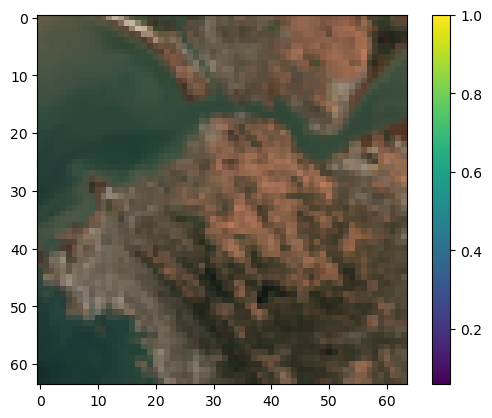

In [301]:
img = patch[0:3,:,:]
# img = img.numpy()
img = img.transpose([1, 2, 0])
plt.imshow(img, vmax=1)
plt.colorbar()
plt.show()

(0.3048, 0.3048)

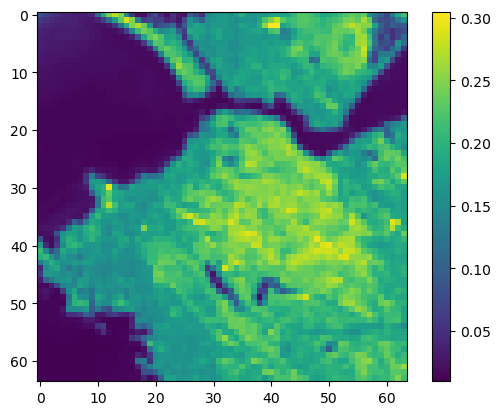

In [302]:
NIR_image = patch[3].squeeze()#-> Remove first dim (channel) 
plt.imshow(NIR_image)#, vmax=1.0)
plt.colorbar()
NIR_image.max(), patch[3].max()

(0.5543341433585548, 0.0)

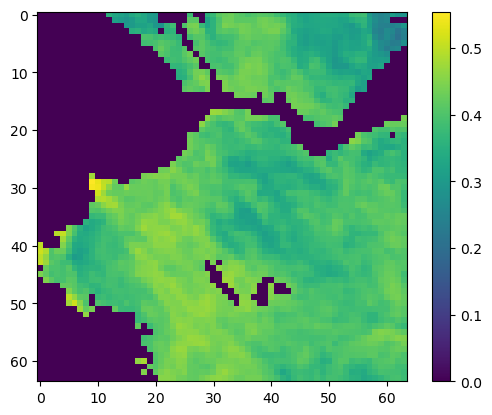

In [303]:
ped = patch[-1].squeeze()#-> Remove first dim (channel) 
plt.imshow(ped)#.permute(1, 2, 0),vmax=1)#, vmax=1.0)
plt.colorbar()
ped.max(), ped.min()

In [62]:
import gc
del train_set
gc.collect()

5539

## Val set

In [44]:
val_set = Dataset(raster_root=s3_raster_path, subset="val", centroids=centroids_val2, observations=ca_val_gdf2, side_len_m=SIDE_LEN_M, side_px=SIDE_PX)

Setting up SI Patch Extractor..
Setting up env raster extractor..
Processing Raster file for  bio_1
Processing Raster file for  bio_2
Processing Raster file for  bio_3
Processing Raster file for  bio_4
Processing Raster file for  bio_5
Processing Raster file for  bio_6
Processing Raster file for  bio_7
Processing Raster file for  bio_8
Processing Raster file for  bio_9
Processing Raster file for  bio_10
Processing Raster file for  bio_11
Processing Raster file for  bio_12
Processing Raster file for  bio_13
Processing Raster file for  bio_14
Processing Raster file for  bio_15
Processing Raster file for  bio_16
Processing Raster file for  bio_17
Processing Raster file for  bio_18
Processing Raster file for  bio_19
Processing Raster file for  bdticm
Processing Raster file for  bldfie
Processing Raster file for  cecsol
Processing Raster file for  clyppt
Processing Raster file for  orcdrc
Processing Raster file for  phihox
Processing Raster file for  sltppt
Processing Raster file for  sndpp

### Test patches extracted

In [ ]:
%%time
(patch2, target2) = val_set[300]

In [46]:
img = patch2[0:3,:,:]
img = img.numpy()
img = img.transpose([1, 2, 0])
plt.imshow(img, vmax=1)
plt.colorbar()
plt.show()

NameError: name 'patch2' is not defined

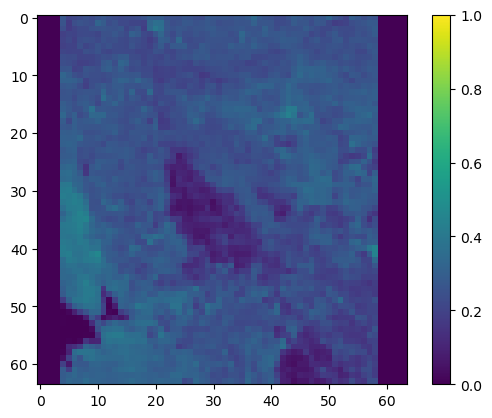

In [191]:
NIR_image = patch2[3].unsqueeze(dim=0)#-> Remove first dim (channel) 
# add a new subplot iteratively

plt.imshow(NIR_image.permute(1, 2, 0),vmax=1)#, vmax=1.0)
plt.colorbar()

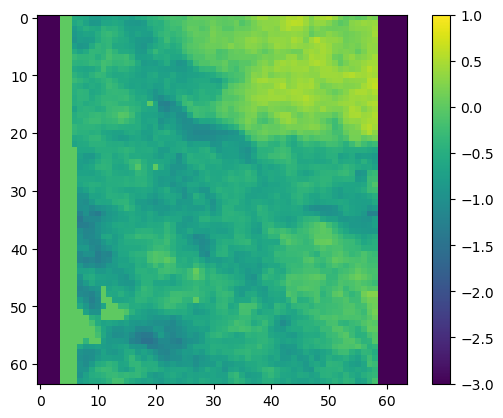

In [192]:
ped = patch2[-1].unsqueeze(dim=0)#-> Remove first dim (channel) 
plt.imshow(ped.permute(1, 2, 0),vmax=1)#, vmax=1.0)
plt.colorbar()

In [193]:
len(target2)

5079

In [183]:
import gc
del val_set
gc.collect()

25307

In [27]:
len(patch)

31

# Dump data to Zarr using a loader

In [25]:
import zarr
import numcodecs

### Create a Zarr dataset with each element consisting of a tuple of patch and target

In [26]:
import warnings
warnings.filterwarnings('ignore')


### Loader testing

In [44]:
BATCH_SIZE = 4
NUM_WORKERS = 2

In [45]:
train_dumper = torch.utils.data.DataLoader(train_set, shuffle=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

In [29]:
BUCKET_NAME = 'datasets-sdm2'
folder = 'geoLifeCLEF/features'
# s3://datasets-sdm2/geoLifeCLEF/features/
filename = 'train_ca.zarr'
s3_feature_path = 's3://{}/{}/{}'.format(BUCKET_NAME, folder, filename)
print(s3_feature_path)

s3://datasets-sdm2/geoLifeCLEF/features/train_ca.zarr


In [35]:
len(train_set)

17173

In [46]:
train_z = zarr.open(s3_feature_path, mode='w', shape=(len(train_set),2), \
                    chunks=(10,None), dtype=object, object_codec=numcodecs.Pickle())

In [47]:
train_z.info

Type,zarr.core.Array
Data type,object
Shape,"(17173, 2)"
Chunk shape,"(10, 2)"
Order,C
Read-only,False
Filter [0],Pickle(protocol=5)
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.FSStore
No. bytes,274768 (268.3K)
No. bytes stored,412


In [317]:
# train_z = zarr.open('data/train_ca.zarr', mode='w', shape=(len(train_set),2), \
#                     chunks=(10,None), dtype=object, object_codec=numcodecs.Pickle())

In [ ]:
from tqdm.notebook import tqdm

# for i in tqdm(range(int(len(train_set)/BATCH_SIZE + 0.5))):
for i, batch in enumerate(tqdm(train_dumper)):
    
    #Patches and targets together
    for j, (p,t) in enumerate(zip(batch[0], batch[1])):
        train_z[j + i*BATCH_SIZE] = (p.numpy(), t.numpy())
        # print("Writing to location [{}]".format(j + i*BATCH_SIZE))
    

  0%|          | 0/4294 [00:00<?, ?it/s]

In [272]:
train_z[16][1].dtype, train_z[51][0].shape

(dtype('uint8'), (31, 64, 64))

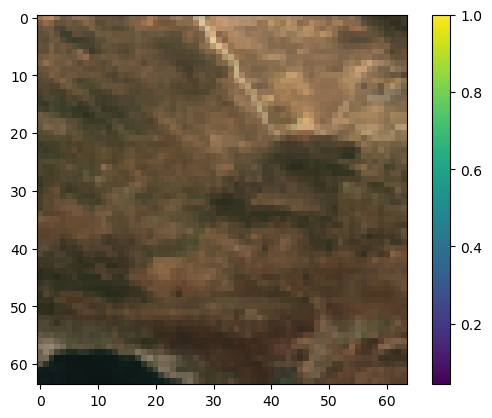

In [276]:
img = train_z[121][0][0:3,:,:]
# img = img.numpy()
img = img.transpose([1, 2, 0])
plt.imshow(img, vmax=1)
plt.colorbar()
plt.show()

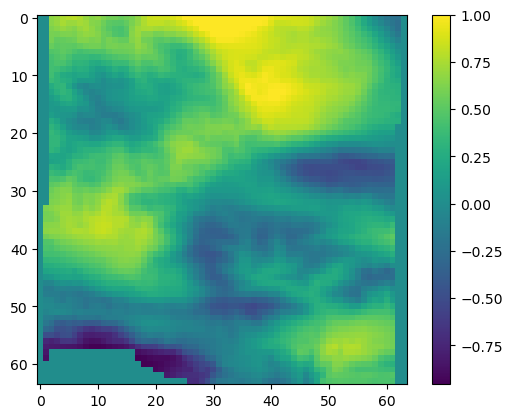

In [277]:
img = train_z[121][0][5,:,:]
# img = img.numpy()
# img = img.transpose([1, 2, 0])
plt.imshow(img, vmax=1)
plt.colorbar()
plt.show()

In [258]:
train_z[51][0][5,:,:]

array([[-5.36402575, -5.36402575,  0.        , ...,  0.        ,
        -5.36402575, -5.36402575],
       [-5.36402575, -5.36402575,  0.        , ...,  0.        ,
        -5.36402575, -5.36402575],
       [-5.36402575, -5.36402575,  0.        , ...,  0.        ,
        -5.36402575, -5.36402575],
       ...,
       [-5.36402575, -5.36402575,  0.        , ...,  0.        ,
        -5.36402575, -5.36402575],
       [-5.36402575, -5.36402575,  0.        , ...,  0.        ,
        -5.36402575, -5.36402575],
       [-5.36402575, -5.36402575,  0.        , ...,  0.        ,
        -5.36402575, -5.36402575]])

### Debug: setting paths for imports

In [1]:
import sys
for path in sys.path:
    print(path)
    

/home/jovyan/sdm-geolifeCLEF
/srv/conda/envs/notebook/lib/python39.zip
/srv/conda/envs/notebook/lib/python3.9
/srv/conda/envs/notebook/lib/python3.9/lib-dynload

/srv/conda/envs/notebook/lib/python3.9/site-packages


In [20]:
# sys.path.remove('/models')
# sys.path.remove('/raster')
# sys.path.remove('model/')
sys.path.remove('/models')
# sys.path.remove('/models')
# sys.path.remove('/raster')
